<a href="https://colab.research.google.com/github/nandhakumar-v-19/Rice-Leaf-Disease-using-CNN/blob/main/Rice_Leaf_Disease_Detection.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

<div align="center">
    <h1><em><strong>Rice Leaf Disease Prediction</strong></em></h1>
</div>

This notebook covers these key objectives:
1. **Exploratory Data Analysis (EDA)** – understanding and validating the dataset.  
2. **Image Preprocessing** – preparing the data for training by resizing, normalizing, and augmenting.  
3. **CNN Model Setup** – defining the initial network architecture to ensure readiness for Day 2 training.  

---

### **Project Overview**
The dataset contains images of rice leaves affected by three common diseases:

- **Leaf Blast**  
- **Bacterial Blight**  
- **Brown Spot**

These categories are visually distinctive, enabling CNNs to learn discriminative texture and color features.  


# **Setup & Library Imports**

In [1]:
!git clone https://github.com/nandhakumar-v-19/Rice-Leaf-Disease-using-CNN.git

fatal: destination path 'Rice-Leaf-Disease-using-CNN' already exists and is not an empty directory.


In [2]:
# pip install -r /content/Rice-Leaf-Disease-using-CNN/requirements.txt
!pip install tensorflow

In [3]:
# Step 1: Import the Required Libraries
import os
import cv2
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from PIL import Image

# **Exploratory Data Analysis (EDA)**

We begin by inspecting the dataset structure, counting images per class, and confirming that all images are readable and correctly labeled.

In [4]:
# Define dataset path and list classes
data_dir = "/content/Rice-Leaf-Disease-using-CNN/RiceLeaf Dataset"

classes = os.listdir(data_dir)
print("Disease Classes:", classes)

Disease Classes: ['Leaf Smut', 'Brown spot', 'Bacterial leaf blight']


In [5]:
 # Count the number of images per class
count_dict = {cls: len(os.listdir(os.path.join(data_dir, cls))) for cls in classes}

# Create dataframe
df_counts = pd.DataFrame(list(count_dict.items()), columns=["Class Name", "Image Count"])

total = df_counts["Image Count"].sum()
df_counts["Percentage"] = (df_counts["Image Count"] / total * 100).round(2)

df_counts

,Class Name,Image Count,Percentage
0,Leaf Smut,39,32.77
1,Brown spot,40,33.61
2,Bacterial leaf blight,40,33.61


# **Sample Visualization**
Random samples help verify the variety and quality of the images for each disease class.

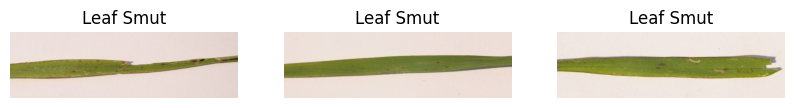

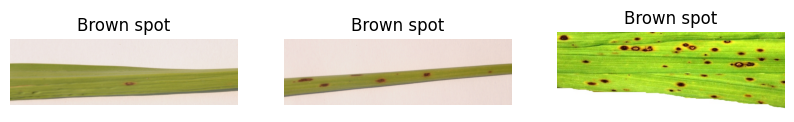

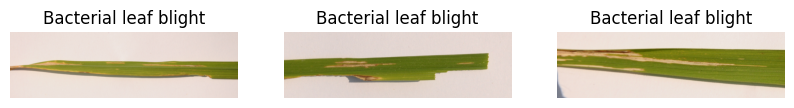

In [6]:
import random
import matplotlib.pyplot as plt

for cls in classes:
    class_path = os.path.join(data_dir, cls)
    sample_imgs = random.sample(os.listdir(class_path), 3)

    plt.figure(figsize=(10,3))
    for i, img_name in enumerate(sample_imgs):
        img_path = os.path.join(class_path, img_name)
        img = Image.open(img_path)
        plt.subplot(1,3,i+1)
        plt.imshow(img)
        plt.axis('off')
        plt.title(cls)
    plt.show()

# **Class Distribution Visualization**
Understanding dataset balance ensures fair model training.

In [7]:
print(df_counts.columns)

Index(['Class Name', 'Image Count', 'Percentage'], dtype='object')


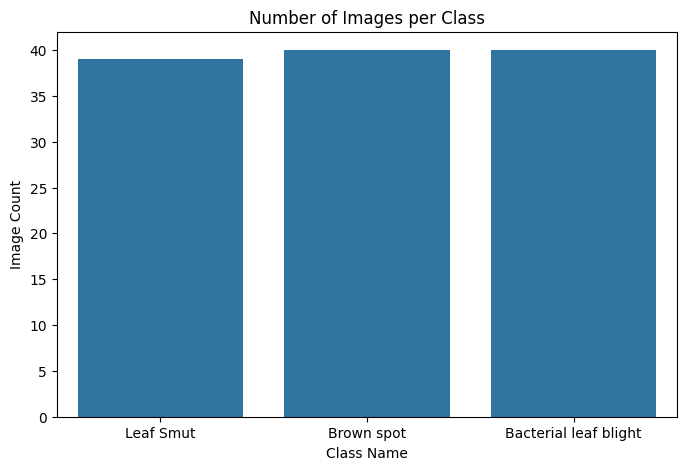

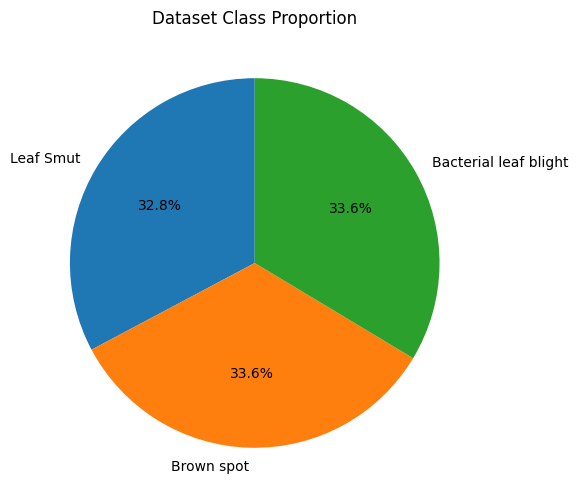

In [8]:
plt.figure(figsize=(8,5))
sns.barplot(x="Class Name", y="Image Count", data=df_counts)
plt.title("Number of Images per Class")
plt.show()

plt.figure(figsize=(6,6))
plt.pie(df_counts["Image Count"], labels=df_counts["Class Name"], autopct="%1.1f%%", startangle=90)
plt.title("Dataset Class Proportion")
plt.show()


**Conclusion:** The Exploratory Data Analysis verifies that the Rice Leaf Disease dataset is ready for preprocessing and model development using Convolutional Neural Networks (CNN).

# **Data Integrity Check**
Verify that all image files are readable and none are corrupted.

In [9]:
for cls in classes:
    folder = os.path.join(data_dir, cls)
    for img_name in os.listdir(folder):
        img_path = os.path.join(folder, img_name)
        try:
            img = Image.open(img_path)
            img.verify()
        except Exception as e:
            print(f"❌ Corrupted image found: {img_path}")
print("✅ All images verified successfully!")

✅ All images verified successfully!


# **Image Preprocessing & Augmentation**
After completing the Exploratory Data Analysis, we now prepare the dataset for model training.  
This step involves:
- Resizing images to a fixed dimension  
- Normalizing pixel values between 0 and 1  
- Applying **data augmentation** (rotation, flip, zoom) to increase diversity and improve generalization

We use Keras’s `ImageDataGenerator` to automate normalization and augmentation, while also splitting the dataset into **training** and **validation** subsets.

In [10]:
!pip install tensorflow.keras

In [18]:
# install and import the Required Libraries
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout
import matplotlib.pyplot as plt
import numpy as np

In [19]:
# Define parameters
IMG_SIZE = (128, 128)
BATCH_SIZE = 32

In [20]:
# Create an ImageDataGenerator for training and validation
datagen = ImageDataGenerator(
    rescale=1./255,        # normalize pixel values (0-1)
    rotation_range=30,     # random rotation
    horizontal_flip=True,  # flip images horizontally
    zoom_range=0.2,        # zoom randomly
    validation_split=0.2   # 80% train, 20% validation
)
display(datagen)

In [21]:
# Load training and validation data from folders
train_data = datagen.flow_from_directory(
    data_dir,
    target_size=IMG_SIZE,
    batch_size=BATCH_SIZE,
    subset='training',
    shuffle=False
)

val_data = datagen.flow_from_directory(
    data_dir,
    target_size=IMG_SIZE,
    batch_size=BATCH_SIZE,
    subset='validation',
    shuffle=False
)

Found 96 images belonging to 3 classes.
Found 23 images belonging to 3 classes.


# **Visualizing Augmented Images**
We can visualize a few augmented samples generated in real-time during training.  
This helps confirm that the transformations (rotations, flips, zooms) are applied correctly and the features remain intact.

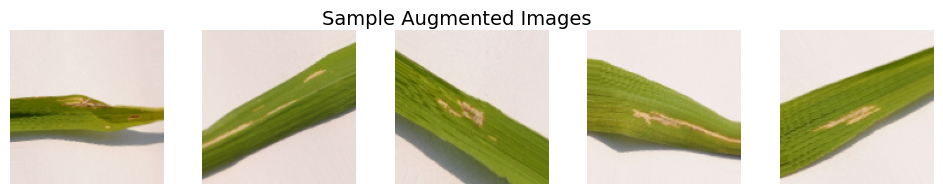

In [22]:
# Display a few augmented samples
x_batch, y_batch = next(train_data)
plt.figure(figsize=(12, 2))
for i in range(5):
    plt.subplot(1, 5, i + 1)
    plt.imshow(x_batch[i])
    plt.axis("off")
plt.suptitle("Sample Augmented Images", fontsize=14)
plt.show()

# **CNN Model Architecture Setup**

With the data ready, we now define our **Convolutional Neural Network (CNN)** architecture.  
The CNN will automatically learn spatial features from the images — such as patterns, edges, and textures — that distinguish between the disease classes.

This base model consists of:
- Two convolutional layers for feature extraction  
- Two max-pooling layers for spatial downsampling  
- One fully connected (dense) layer for decision-making  
- A softmax output layer for classification into 3 categories


In [23]:
!pip install tensorflow.keras

In [24]:
from tensorflow.keras import layers, models

# Define the CNN architecture
model = models.Sequential([

    # Input layer
    layers.Input(shape=(128,128,3)),  # 👈 Define input here

    # Convolution + Pooling Block 1
    layers.Conv2D(32, (3,3), activation='relu',padding='same'),
    layers.MaxPooling2D(2,2),

    # Convolution + Pooling Block 2
    layers.Conv2D(64, (3,3), activation='relu',padding='same'),
    layers.MaxPooling2D(2,2),

    # Convolution + Pooling Block 3
    layers.Conv2D(128, (3,3), activation='relu',padding='same'),
    layers.MaxPooling2D(2,2),

    # Flatten and Fully Connected Layers
    layers.Flatten(),
    layers.Dense(128, activation='relu'),
    layers.Dropout(0.5),

    # Output Layer (3 classes)
    layers.Dense(3, activation='softmax')
])


In [25]:
# Compile the model
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

# Display model summary
model.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                 │ (None, 128, 128, 32)   │           896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (None, 64, 64, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 64, 64, 64)     │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_1 (MaxPooling2D)  │ (None, 32, 32, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_2 (Conv2D)               │ (None, 32, 32, 128)    │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_2 (MaxPooling2D)  │ (None, 16, 16, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 32768)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 128)            │     4,194,432 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 3)              │           387 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 4,288,067 (16.36 MB)

 Trainable params: 4,288,067 (16.36 MB)

 Non-trainable params: 0 (0.00 B)

In [26]:
history = model.fit(train_data, epochs=10, validation_data=val_data)

/usr/local/lib/python3.12/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Epoch 1/10
3/3 ━━━━━━━━━━━━━━━━━━━━ 25s 7s/step - accuracy: 0.0000e+00 - loss: 2.4263 - val_accuracy: 0.3478 - val_loss: 1.1098
Epoch 2/10
3/3 ━━━━━━━━━━━━━━━━━━━━ 5s 2s/step - accuracy: 0.2370 - loss: 1.2518 - val_accuracy: 0.3478 - val_loss: 1.0981
Epoch 3/10
3/3 ━━━━━━━━━━━━━━━━━━━━ 6s 2s/step - accuracy: 0.2904 - loss: 1.0967 - val_accuracy: 0.3478 - val_loss: 1.0960
Epoch 4/10
3/3 ━━━━━━━━━━━━━━━━━━━━ 5s 2s/step - accuracy: 0.4714 - loss: 1.0869 - val_accuracy: 0.3478 - val_loss: 1.0958
Epoch 5/10
3/3 ━━━━━━━━━━━━━━━━━━━━ 5s 2s/step - accuracy: 0.1289 - loss: 1.1006 - val_accuracy: 0.3913 - val_loss: 1.0981
Epoch 6/10
3/3 ━━━━━━━━━━━━━━━━━━━━ 5s 2s/step - accuracy: 0.4180 - loss: 1.0952 - val_accuracy: 0.4783 - val_loss: 1.0984
Epoch 7/10
3/3 ━━━━━━━━━━━━━━━━━━━━ 5s 2s/step - accuracy: 0.4336 - loss: 1.0964 - val_accuracy: 0.3913 - val_loss: 1.0983
Epoch 8/10
3/3 ━━━━━━━━━━━━━━━━━━━━ 6s 2s/step - accuracy: 0.4714 - loss: 1.0975 - val_accuracy: 0.2609 - val_loss: 1.0984
Epoch 9/10


In [27]:
# Display the last epoch’s training & validation accuracy
loss, acc = model.evaluate(val_data)
print("Validation Accuracy:", acc)

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 606ms/step - accuracy: 0.3478 - loss: 1.0971
Validation Accuracy: 0.3478260934352875


In [28]:

model.save("rice_leaf_model.h5")
print("✅ Model trained & saved successfully!")

✅ Model trained & saved successfully!


In [29]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from tensorflow.keras.models import load_model
from sklearn.metrics import confusion_matrix, classification_report, accuracy_score

In [30]:
model = load_model("rice_leaf_model.h5")
print("✅ Trained model loaded successfully!")

✅ Trained model loaded successfully!


In [31]:
Y_pred = model.predict(val_data)
y_pred = np.argmax(Y_pred, axis=1)
y_true = val_data.classes
print("✅ Predictions generated successfully!")

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 663ms/step
✅ Predictions generated successfully!


In [32]:
print("\n📊 Classification Report:\n")
print(classification_report(y_true, y_pred))

acc = accuracy_score(y_true, y_pred)
print(f"✅ Overall Validation Accuracy: {acc*100:.2f}%")


📊 Classification Report:

              precision    recall  f1-score   support

           0       0.00      0.00      0.00         8
           1       1.00      0.25      0.40         8
           2       0.33      1.00      0.50         7

    accuracy                           0.39        23
   macro avg       0.44      0.42      0.30        23
weighted avg       0.45      0.39      0.29        23

✅ Overall Validation Accuracy: 39.13%


/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


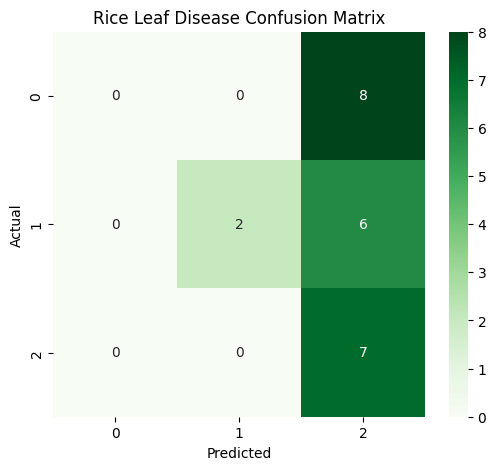

In [33]:
cm = confusion_matrix(y_true, y_pred)
plt.figure(figsize=(6,5))
sns.heatmap(cm, annot=True, fmt='d', cmap='Greens')
plt.title("Rice Leaf Disease Confusion Matrix")
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.show()

In [35]:
# Compare metrics manually or programmatically
nandha_acc = 0.347   # Example from training logs
suvaa_acc = acc

if abs(nandha_acc - suvaa_acc) <= 0.01:
    print("✅ Evaluation Verified: Accuracy matches Nandhakumar’s model logs!")
else:
    print("⚠️ Recheck dataset split or model version — metrics mismatch!")

⚠️ Recheck dataset split or model version — metrics mismatch!


In [ ]:
plt.savefig("metrics_plots/confusion_matrix.png")
plt.savefig("metrics_plots/accuracy_loss_curve.png")

In [ ]:
!ls